In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do linear regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [74]:
hourly_nighlty_threshold = 50

# Linear Regression Regression Analysis Of Solar and Weather



In [75]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [76]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

In [77]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [152]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
feature_cols.append('Dew Point(C)_Lag1')
feature_cols.append('Temp_Lag1')
feature_cols.append('Humidity_Lag1')
feature_cols.append('WindSpeed_Lag1')
#feature_cols.append('Dew Point(C)_Lag24')
#feature_cols.append('Temp_Lag24')
#feature_cols.append('Humidity_Lag24')
#feature_cols.append('WindSpeed_Lag24')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
#feature_cols.append('Total_Power_ClearSky_Output(W)_Lag24')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Linear Regression with target: {target_col} and features: {feature_cols}")



Testing Linear Regression with target: Clearsky_Index and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'Dew Point(C)_Lag1', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [153]:

print(f"\nTesting Linear Regression with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Save test and training x and y to feather files
# This allows later analysis without needing to redo the train test split
X_train.to_pickle(f"{TRAIN_DATA_DIR}/X_train_test_no_{test_no}.pickle")
y_train.to_pickle(f"{TRAIN_DATA_DIR}/y_train_test_no_{test_no}.pickle")
X_test.to_pickle(f"{TRAIN_DATA_DIR}/X_test_test_no_{test_no}.pickle")
y_test.to_pickle(f"{TRAIN_DATA_DIR}/y_test_test_no_{test_no}.pickle")
# Also put test no , name and notes in a dataframe and save as feather
test_info_df = pd.DataFrame({
    "Test No": [test_no],
    "Test Name": [test_name],
    "Notes": [notes],
    'target_col': [target_col],
    'feature_cols': [feature_cols]
})
test_info_df.to_feather(f"{TRAIN_DATA_DIR}/test_info_test_no_{test_no}.pickle")



Testing Linear Regression with target: Clearsky_Index and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'Dew Point(C)_Lag1', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
X_train shape: (2192, 26)
y_train shape: (2192,)
X_test shape: (2194, 26)
y_test shape: (2194,)


In [154]:
lr_model = LinearRegression()
# Train the model
print("Fitting model...")
lr_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_test_pred = lr_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
print("Making predictions on training set...")
y_train_pred = lr_model.predict(X_train)
print("Making predictions on training set... Done")

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...
Making predictions on training set... Done


In [155]:

print(f"Target Column {target_col}")
# Depending on target column, inverse transform if necessary
if target_col in ['PV(W)']:
    print("No inverse transformation needed for PV(W)")
    y_train_pvw_pred = y_train_pred
    y_train_pvw = y_train
    y_test_pvw_pred = y_test_pred
    y_test_pvw = y_test
elif target_col in ['PV(W)_error']:
    print("Inverse transforming PV(W)_error to PV(W)")
    y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']
if target_col in ['Clearsky_Index']:   
    print("Inverse transforming Clearsky_Index to PV(W)")
    y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
elif target_col in ['PV(W)_error_index']:
    print("Inverse transforming PV(W)_error_index to PV(W)")
    y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']

# Clip negative predictions to 0
y_train_pvw_pred = y_train_pvw_pred.clip(lower=0)
y_test_pvw_pred = y_test_pvw_pred.clip(lower=0)

Target Column Clearsky_Index
Inverse transforming Clearsky_Index to PV(W)


__Metrics for Tests 

In [156]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do linear regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# do linear regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown(f"### Linear Regression Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100
)
from IPython.display import display, Markdown
# Change this line in Cell 13
display(Markdown(f"### Linear Regression Performance Metrics {target_col}\n" + mk_string))

### Linear Regression Performance Metrics Clearsky_Index
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 0.20              | 0.22              |
| MAE          | 0.16              | 0.17              |
| R2           | 0.5192              | 0.4102              |
| N-RMSE (%)   | 13.5214              | 11.6781              |
| N-MAE (%)    | 10.7438              | 9.0657              |
| Accuracy (%) | 68.5598              | 69.5915              |

### Linear Regression Performance Metrics Clearsky_Index
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 665.82              | 696.44              |
| MAE          | 496.90              | 519.71              |
| R2           | 0.7808              | 0.7468              |
| N-RMSE (%)   | 11.8499              | 12.4219              |
| N-MAE (%)    | 8.8435              | 9.2696              |
| Accuracy (%) | 71.8760              | 72.7239              |

In [157]:
# NOTE: Feature importance and Monte Carlo uncertainty analysis are not applicable to Linear Regression
# These are Random Forest specific features that have been commented out
# feature importance plot
# importances = lr_model.feature_importances_
# feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# importances = lr_model.feature_importances_
# feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# filter out all features with importance less than 0.01
#feature_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.01]
# plot feature importance using seaborn barplot


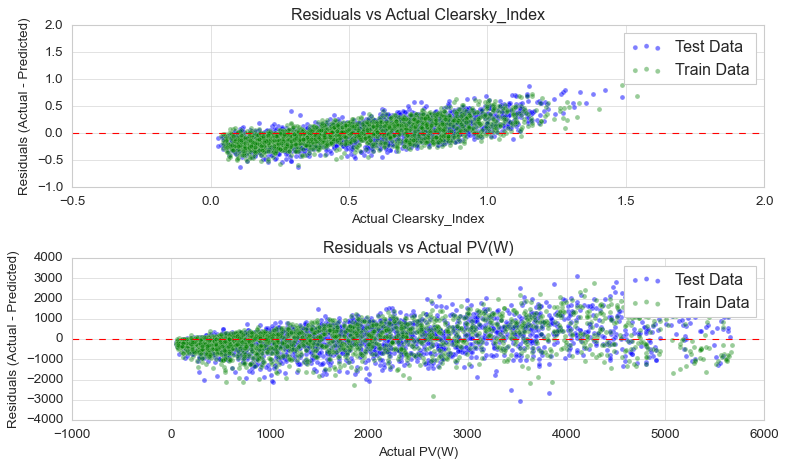

In [158]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()




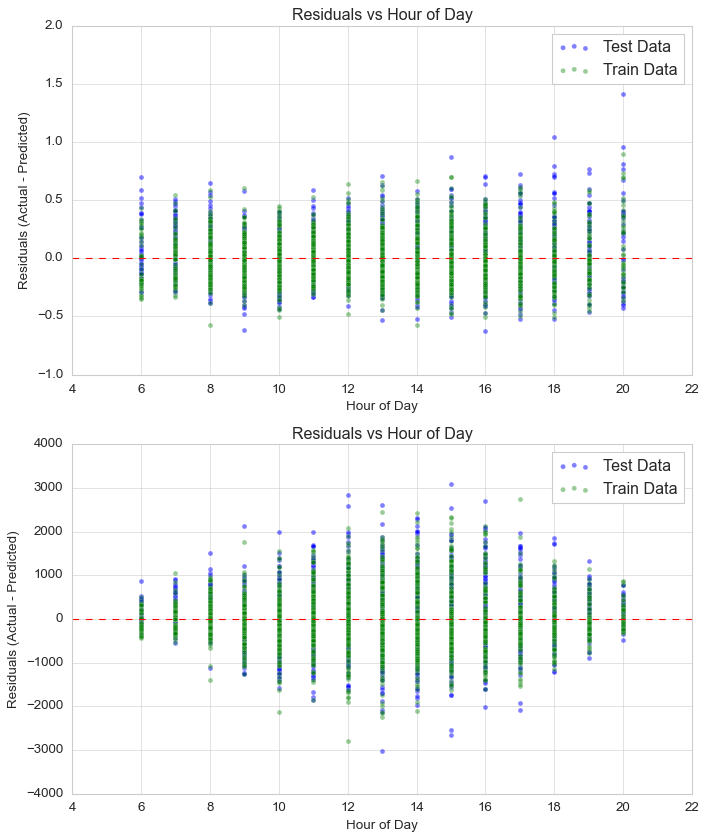

In [159]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

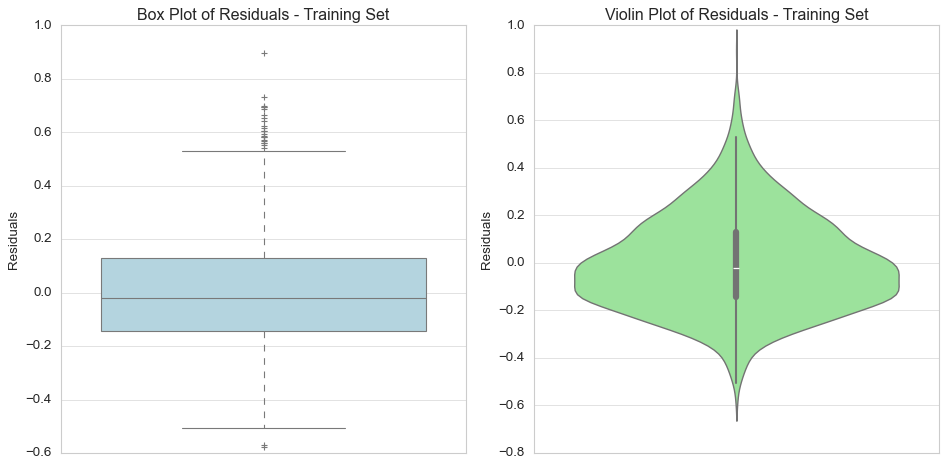

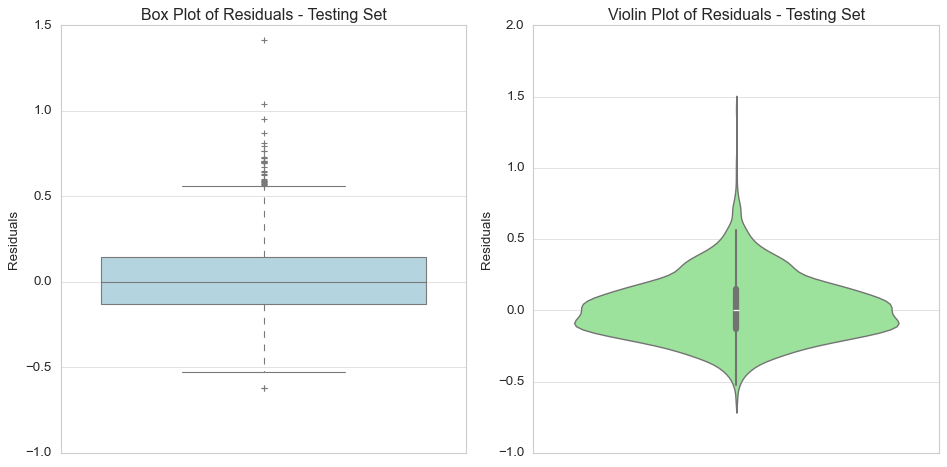

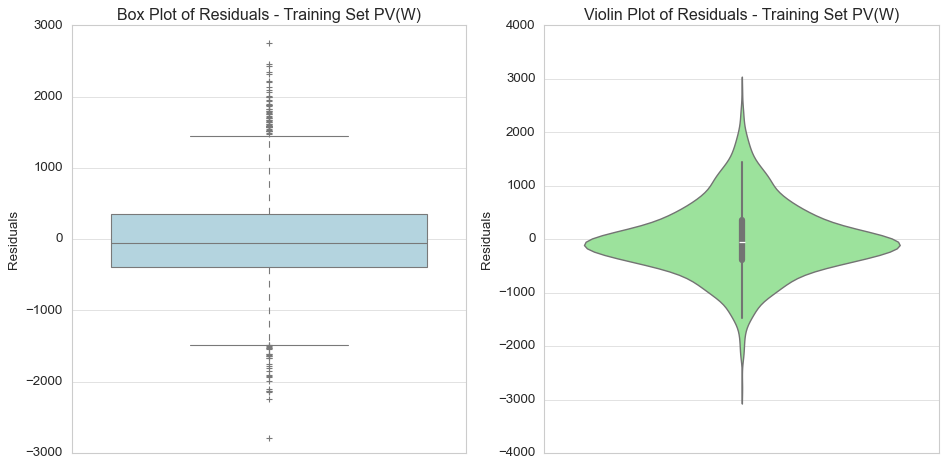

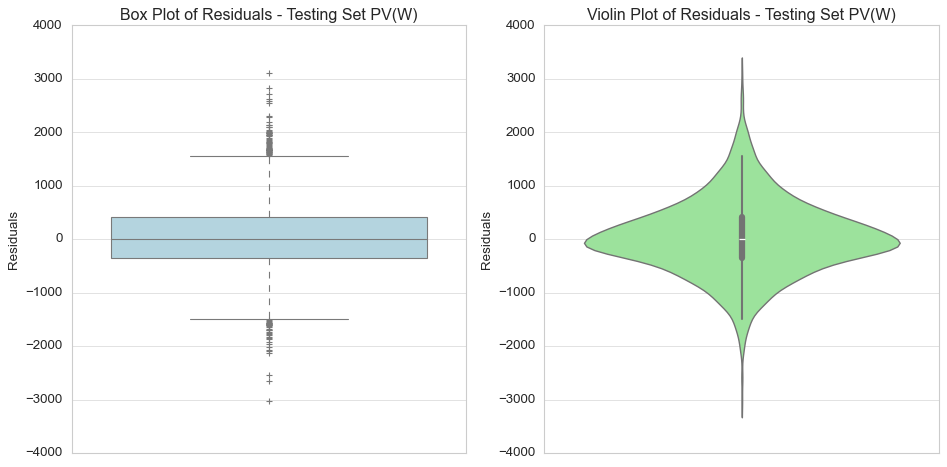

In [160]:
# Plot box plot and violin plot of residuals for test and train
import numpy as np

# Ensure required data is available (use existing objects if already loaded)
if 'y_train' not in globals() or 'y_test' not in globals():
    X_train = df_daytime_train[feature_cols]
    y_train = df_daytime_train[target_col]
    X_test = df_daytime_test[feature_cols]
    y_test = df_daytime_test[target_col]

if 'y_train_pred' not in globals() or 'y_test_pred' not in globals():
    if 'lr_model' not in globals():
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)

if 'y_train_pvw' not in globals() or 'y_train_pvw_pred' not in globals():
    if target_col == 'PV(W)':
        y_train_pvw_pred = y_train_pred
        y_train_pvw = y_train
        y_test_pvw_pred = y_test_pred
        y_test_pvw = y_test
    elif target_col == 'PV(W)_error':
        y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
        y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
        y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
        y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']
    elif target_col == 'Clearsky_Index':
        y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
        y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
        y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
        y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
    elif target_col == 'PV(W)_error_index':
        y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
        y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
        y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
        y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_train_pvw_pred = y_train_pvw_pred.clip(lower=0)
    y_test_pvw_pred = y_test_pvw_pred.clip(lower=0)

def plot_residuals_box_violin(y_true, y_pred, title):
    # Ensure 1D numpy arrays for seaborn
    y_true_flat = np.asarray(y_true).reshape(-1)
    y_pred_flat = np.asarray(y_pred).reshape(-1)
    residuals = y_true_flat - y_pred_flat

    # Drop NaNs or infs to avoid seaborn issues
    residuals = residuals[np.isfinite(residuals)]

    plt.figure(figsize=(12, 6))

    # Box Plot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=residuals, color='lightblue')
    plt.title(f"Box Plot of Residuals - {title}")
    plt.ylabel("Residuals")

    # Violin Plot
    plt.subplot(1, 2, 2)
    sns.violinplot(y=residuals, color='lightgreen')
    plt.title(f"Violin Plot of Residuals - {title}")
    plt.ylabel("Residuals")

    plt.tight_layout()
    plt.show()

plot_residuals_box_violin(y_train, y_train_pred, "Training Set")
plot_residuals_box_violin(y_test, y_test_pred, "Testing Set")
# Also plot for PV(W)
plot_residuals_box_violin(y_train_pvw, y_train_pvw_pred, "Training Set PV(W)")
plot_residuals_box_violin(y_test_pvw, y_test_pvw_pred, "Testing Set PV(W)")

__Residual Contour Plots__

This should a contour of the veritcal axis as hours of day , and the horizontal axis as month of the year , the blue indicates over-confidence . That is the model predicts more than was produced . The red , under-confidence.  The darker the colour the bigger the error . The error gets greater the more the sun is available . That a 10 percent error for 100 W , is 10 W's and for 1000 W that is 100 W . Thus at midday there is larget error than there is in the morning. 



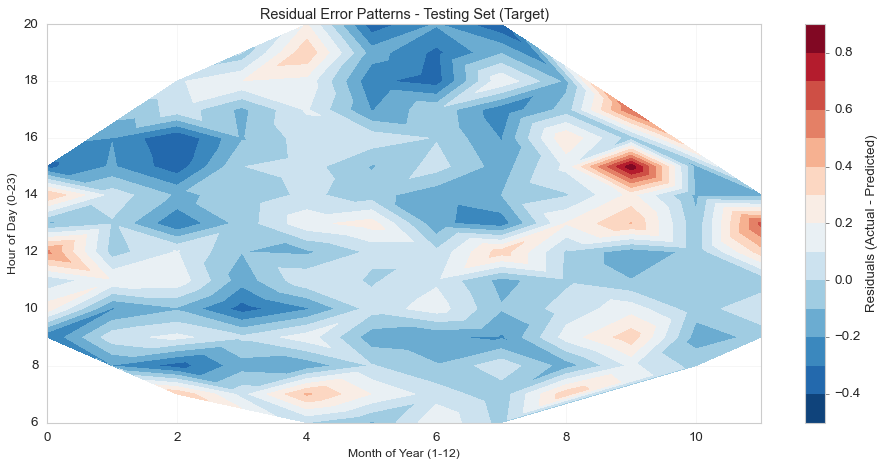

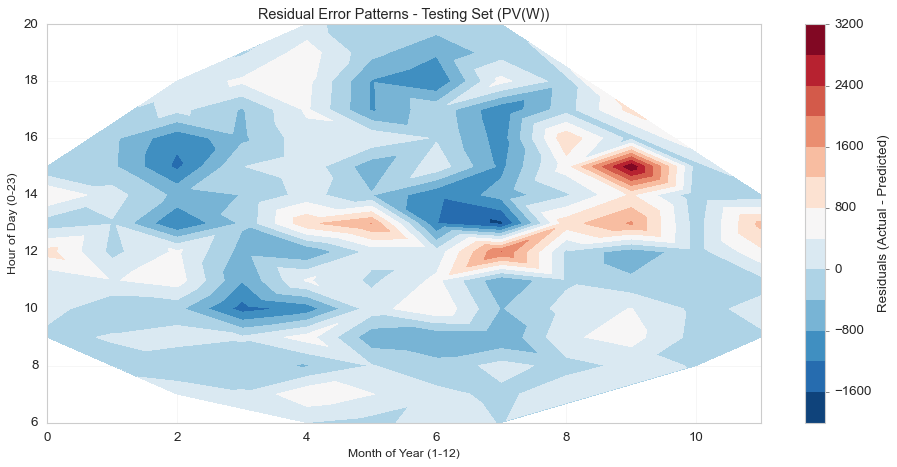

In [161]:
# Plot a contour map of month vs hour showing residuals
# Visualize error patterns across different times of year and day

def plot_residuals_contour(y_true, y_pred, month_sin, hour_sin, title, month_cos=None, hour_cos=None):
    """
    Plot residuals as a contour map over month of year and hour of day.
    
    Args:
        y_true, y_pred: actual and predicted values
        month_sin, hour_sin: sin-encoded month and hour values (pandas Series or numpy arrays)
        title: plot title
        month_cos, hour_cos: optional cosine-encoded month and hour for accurate inversion
    """
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = (y_true - y_pred).ravel()
    
    # Convert Series to numpy arrays if needed
    if hasattr(month_sin, 'values'):
        month_sin = month_sin.values
    if hasattr(hour_sin, 'values'):
        hour_sin = hour_sin.values
    month_sin = np.asarray(month_sin).ravel()
    hour_sin = np.asarray(hour_sin).ravel()
    
    if month_cos is not None and hasattr(month_cos, 'values'):
        month_cos = month_cos.values
    if hour_cos is not None and hasattr(hour_cos, 'values'):
        hour_cos = hour_cos.values
    if month_cos is not None:
        month_cos = np.asarray(month_cos).ravel()
    if hour_cos is not None:
        hour_cos = np.asarray(hour_cos).ravel()
    
    # Recover month (1-12) and hour (0-23) from sin/cos if available, else approximate from sin only
    if month_cos is not None and hour_cos is not None:
        # atan2 gives angles in [-pi, pi]; shift to [0, 2*pi]
        month_angle = (np.arctan2(month_sin, month_cos) + 2 * np.pi) % (2 * np.pi)
        hour_angle = (np.arctan2(hour_sin, hour_cos) + 2 * np.pi) % (2 * np.pi)
        month = (month_angle / (2 * np.pi)) * 12  # 0..12
        hour = (hour_angle / (2 * np.pi)) * 24    # 0..24
    else:
        # Fallback (ambiguous): use arcsin to map to [0, 1] then scale
        month = (np.arcsin(np.clip(month_sin, -0.999, 0.999)) + np.pi / 2) / (2 * np.pi) * 12
        hour = (np.arcsin(np.clip(hour_sin, -0.999, 0.999)) + np.pi / 2) / (2 * np.pi) * 24

    plt.figure(figsize=(12, 6))
    contour = plt.tricontourf(month, hour, residuals, levels=15, cmap='RdBu_r')
    plt.colorbar(contour, label='Residuals (Actual - Predicted)')
    plt.title(f"Residual Error Patterns - {title}", fontsize=13)
    plt.xlabel("Month of Year (1-12)", fontsize=11)
    plt.ylabel("Hour of Day (0-23)", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ensure required variables are available before plotting
if 'y_test' not in locals() or 'y_test_pred' not in locals():
    print("Error: y_test and y_test_pred are not defined. Please run the model training and prediction cells first.")
else:
    # Plot contour maps for test set
    plot_residuals_contour(
        y_test,
        y_test_pred,
        df_daytime_test['Month_Sin'],
        df_daytime_test['HourOfDay_Sin'],
        "Testing Set (Target)",
        month_cos=df_daytime_test.get('Month_Cos'),
        hour_cos=df_daytime_test.get('HourOfDay_Cos')
    )
    plot_residuals_contour(
        y_test_pvw,
        y_test_pvw_pred,
        df_daytime_test['Month_Sin'],
        df_daytime_test['HourOfDay_Sin'],
        "Testing Set (PV(W))",
        month_cos=df_daytime_test.get('Month_Cos'),
        hour_cos=df_daytime_test.get('HourOfDay_Cos')
    )


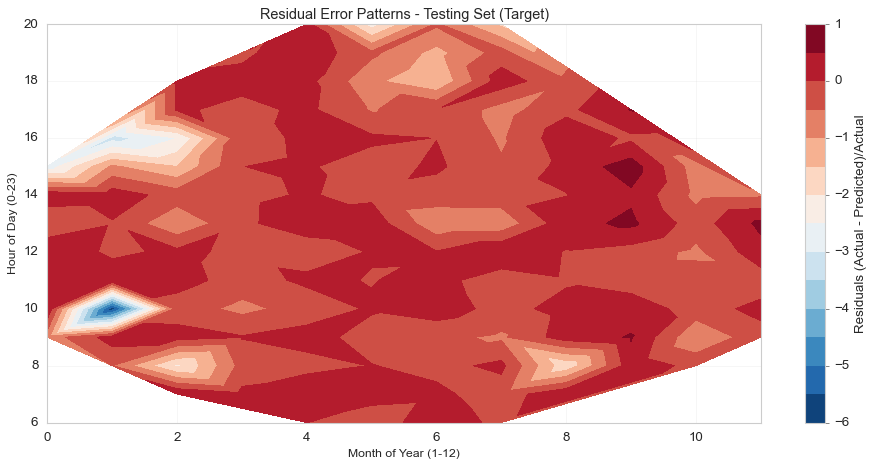

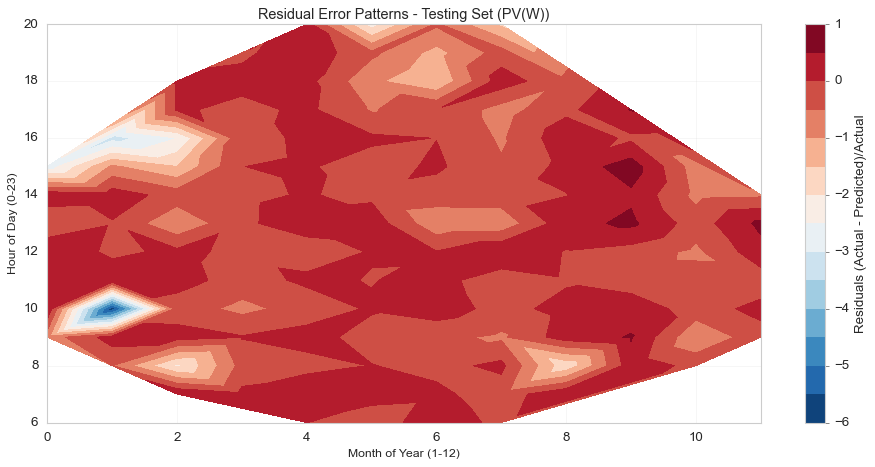

In [162]:
# plot a contour plot of residual as a percentage of actual rather than absolute error
# Plot a contour map of month vs hour showing residuals
# Visualize error patterns across different times of year and day

def plot_residuals_ratio_contour(y_true, y_pred, month_sin, hour_sin, title, month_cos=None, hour_cos=None):
    """
    Plot residuals as a contour map over month of year and hour of day.
    
    Args:
        y_true, y_pred: actual and predicted values
        month_sin, hour_sin: sin-encoded month and hour values (pandas Series or numpy arrays)
        title: plot title
        month_cos, hour_cos: optional cosine-encoded month and hour for accurate inversion
    """
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # remove all zero values from y_true
    residuals = (y_true - y_pred)/y_true.ravel()
    
    # Convert Series to numpy arrays if needed
    if hasattr(month_sin, 'values'):
        month_sin = month_sin.values
    if hasattr(hour_sin, 'values'):
        hour_sin = hour_sin.values
    month_sin = np.asarray(month_sin).ravel()
    hour_sin = np.asarray(hour_sin).ravel()
    
    if month_cos is not None and hasattr(month_cos, 'values'):
        month_cos = month_cos.values
    if hour_cos is not None and hasattr(hour_cos, 'values'):
        hour_cos = hour_cos.values
    if month_cos is not None:
        month_cos = np.asarray(month_cos).ravel()
    if hour_cos is not None:
        hour_cos = np.asarray(hour_cos).ravel()
    
    # Recover month (1-12) and hour (0-23) from sin/cos if available, else approximate from sin only
    if month_cos is not None and hour_cos is not None:
        # atan2 gives angles in [-pi, pi]; shift to [0, 2*pi]
        month_angle = (np.arctan2(month_sin, month_cos) + 2 * np.pi) % (2 * np.pi)
        hour_angle = (np.arctan2(hour_sin, hour_cos) + 2 * np.pi) % (2 * np.pi)
        month = (month_angle / (2 * np.pi)) * 12  # 0..12
        hour = (hour_angle / (2 * np.pi)) * 24    # 0..24
    else:
        # Fallback (ambiguous): use arcsin to map to [0, 1] then scale
        month = (np.arcsin(np.clip(month_sin, -0.999, 0.999)) + np.pi / 2) / (2 * np.pi) * 12
        hour = (np.arcsin(np.clip(hour_sin, -0.999, 0.999)) + np.pi / 2) / (2 * np.pi) * 24

    plt.figure(figsize=(12, 6))
    contour = plt.tricontourf(month, hour, residuals, levels=15, cmap='RdBu_r')
    plt.colorbar(contour, label='Residuals (Actual - Predicted)/Actual')
    plt.title(f"Residual Error Patterns - {title}", fontsize=13)
    plt.xlabel("Month of Year (1-12)", fontsize=11)
    plt.ylabel("Hour of Day (0-23)", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ensure required variables are available before plotting
if 'y_test' not in locals() or 'y_test_pred' not in locals():
    print("Error: y_test and y_test_pred are not defined. Please run the model training and prediction cells first.")
else:
    # Plot contour maps for test set
    plot_residuals_ratio_contour(
        y_test,
        y_test_pred,
        df_daytime_test['Month_Sin'],
        df_daytime_test['HourOfDay_Sin'],
        "Testing Set (Target)",
        month_cos=df_daytime_test.get('Month_Cos'),
        hour_cos=df_daytime_test.get('HourOfDay_Cos')
    )
    plot_residuals_ratio_contour(
        y_test_pvw,
        y_test_pvw_pred,
        df_daytime_test['Month_Sin'],
        df_daytime_test['HourOfDay_Sin'],
        "Testing Set (PV(W))",
        month_cos=df_daytime_test.get('Month_Cos'),
        hour_cos=df_daytime_test.get('HourOfDay_Cos')
    )


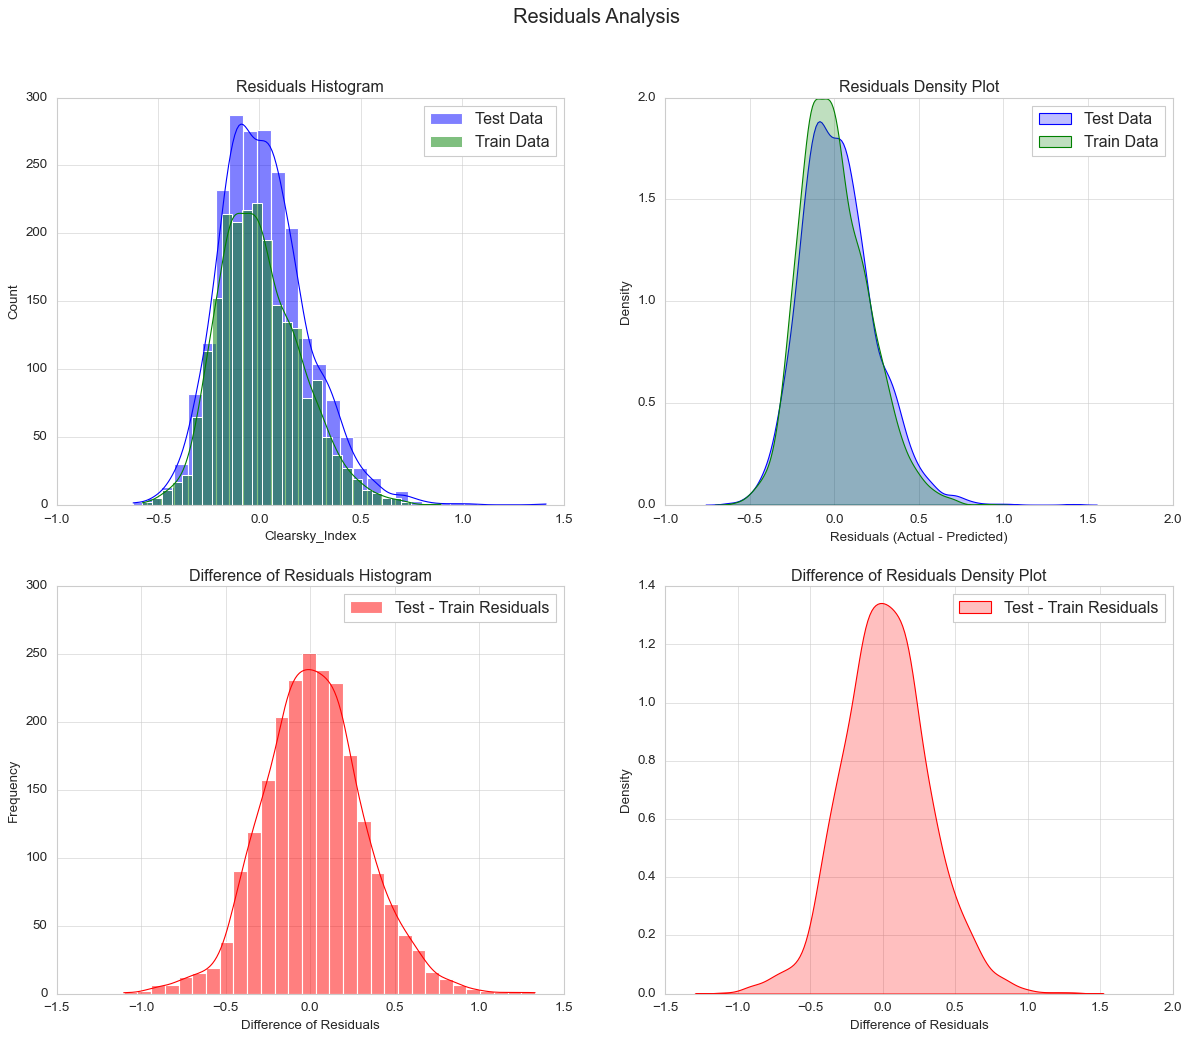

In [163]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

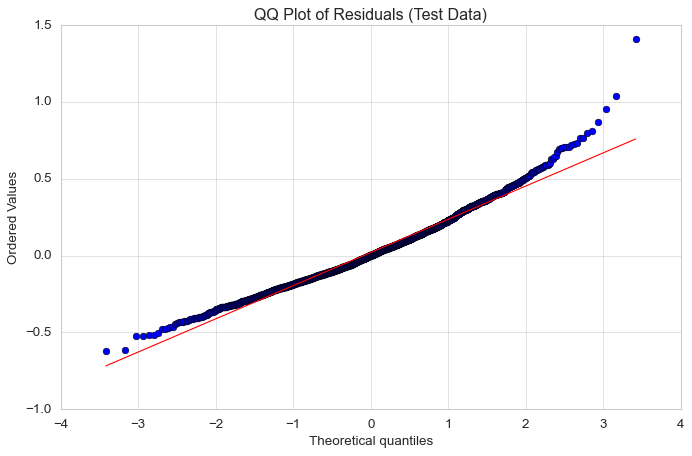

In [164]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


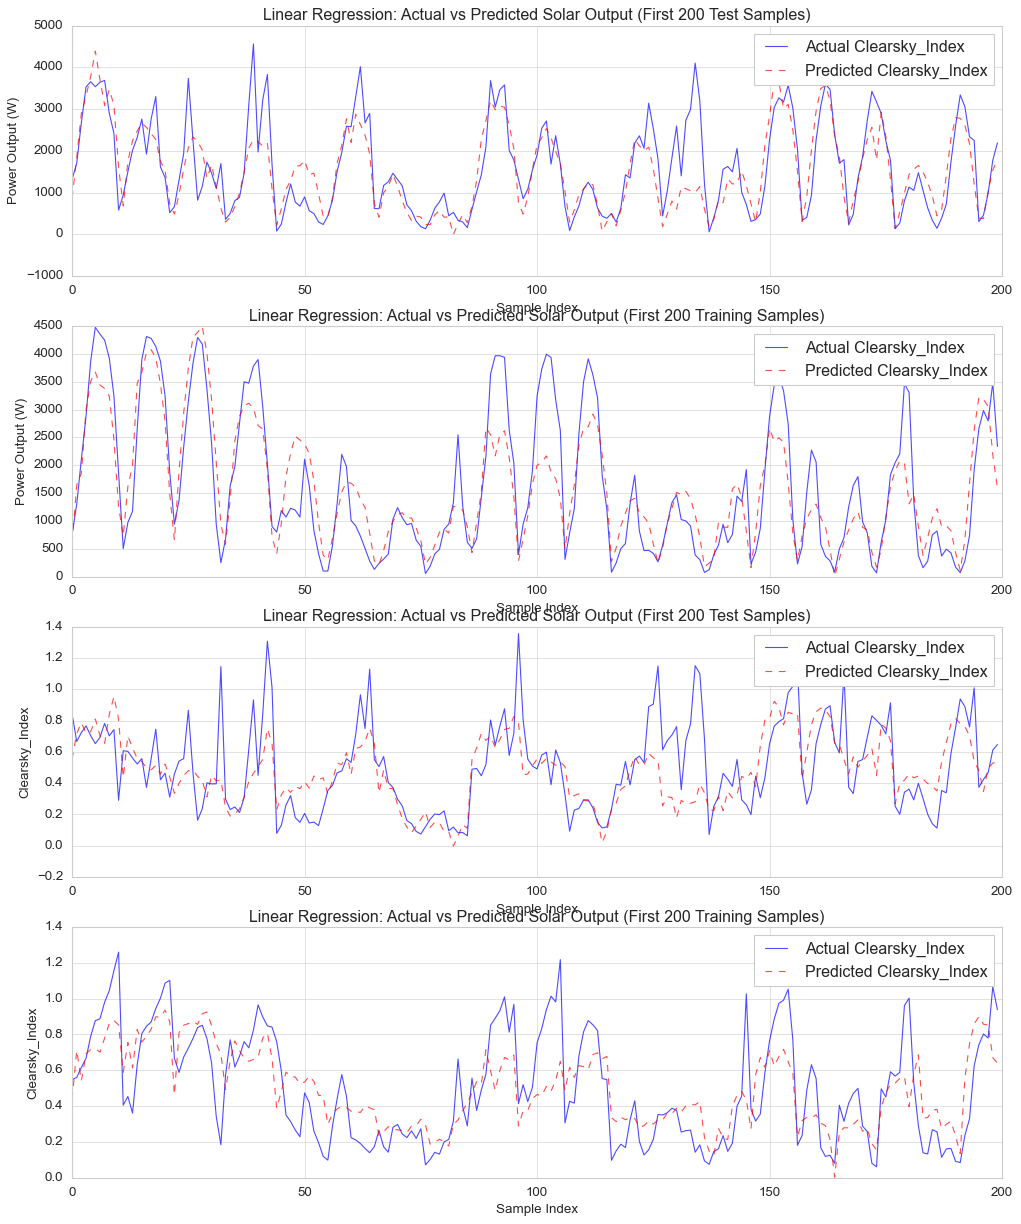

In [165]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Linear Regression: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

This is too to investigate if using the media as an alternative to mean gives a beter result.


Note: Gemini Prompt to generate the code

In [166]:
# NOTE: Feature importance and Monte Carlo uncertainty analysis are not applicable to Linear Regression
# These are Random Forest specific features that have been commented out
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# 
# 1. Gather predictions from all individual trees
# print("Gathering predictions from all trees... (this might take a moment)")
# We use .values to avoid the "feature names" warning
# all_tree_preds = np.array([tree.predict(X_test.values) for tree in lr_model.estimators_])
# 
# 2. Calculate Median and Mean Predictions
# y_pred_median = np.median(all_tree_preds, axis=0)
# y_pred_mean = lr_model.predict(X_test)
# 
# 3. Calculate Standard Metrics
# mae_median = mean_absolute_error(y_test, y_pred_median)
# rmse_median = np.sqrt(mean_squared_error(y_test, y_pred_median))
# 
# mae_mean = mean_absolute_error(y_test, y_pred_mean)
# rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
# 
# 4. Calculate Normalized Metrics
# We divide by the average of the actual values (y_test.mean())
# You could also use (y_test.max() - y_test.min()) if preferred
# normalization_factor = y_test.mean()
# 
# n_mae_median = mae_median / normalization_factor
# n_rmse_median = rmse_median / normalization_factor
# 
# n_mae_mean = mae_mean / normalization_factor
# n_rmse_mean = rmse_mean / normalization_factor
# 
# 5. Print Results with Percentages
# print(f"\n--- Model Performance Comparison ---")
# print(f"Normalization Factor (Mean of Actuals): {normalization_factor:.2f} W")
# 
# print(f"\n1. Standard Linear Regression (Mean):")
# print(f"   MAE:    {mae_mean:.2f} W")
# print(f"   nMAE:   {n_mae_mean:.4f} ({n_mae_mean*100:.2f}%)")
# print(f"   RMSE:   {rmse_mean:.2f} W")
# print(f"   nRMSE:  {n_rmse_mean:.4f} ({n_rmse_mean*100:.2f}%)")
# 
# print(f"\n2. Median Linear Regression (Median):")
# print(f"   MAE:    {mae_median:.2f} W")
# print(f"   nMAE:   {n_mae_median:.4f} ({n_mae_median*100:.2f}%)")
# print(f"   RMSE:   {rmse_median:.2f} W")
# print(f"   nRMSE:  {n_rmse_median:.4f} ({n_rmse_median*100:.2f}%)")
# 
# Check which is better
# if n_mae_median < n_mae_mean:
#     print(f"\n✅ Success! The Median method reduced the nMAE by {(n_mae_mean - n_mae_median)*100:.2f}%")
# else:
#     print(f"\nℹ️ The Standard Mean method was better by {(n_mae_median - n_mae_mean)*100:.2f}%")

Investigate what the impact to clipping is on the MAE , RMSE and R2

In [167]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Generate Base Predictions (if you haven't already) ---
# We need the model's raw predictions (the errors/residuals) first
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# --- 2. Reconstruct the Total PV Values (Correcting the Typos) ---

# Train Set Reconstruction
# We add the 'ClearSky' base model back to our residuals to get total Watts
y_train_actual_reconstructed = (y_train + df_daytime_train['Total_Power_ClearSky_Output(W)'])
y_train_pred_reconstructed   = (y_train_pred + df_daytime_train['Total_Power_ClearSky_Output(W)'])

# Test Set Reconstruction (FIXED: Using df_daytime_test and y_test)
y_test_actual_reconstructed = (y_test + df_daytime_test['Total_Power_ClearSky_Output(W)'])
y_test_pred_reconstructed   = (y_test_pred + df_daytime_test['Total_Power_ClearSky_Output(W)'])

# --- 3. Apply Clipping (No Negative Solar Power) ---
# It's physically impossible to have negative power, so we clip at 0
y_train_actual_clipped = y_train_actual_reconstructed.clip(lower=0)
y_train_pred_clipped   = y_train_pred_reconstructed.clip(lower=0)

y_test_actual_clipped = y_test_actual_reconstructed.clip(lower=0)
y_test_pred_clipped   = y_test_pred_reconstructed.clip(lower=0)


# --- 4. The "Magic" Function to Calculate & Print Stats ---
def print_solar_metrics(y_true, y_pred, label="Data"):
    # Basic Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Normalized Metrics (Dividing by the Mean of the Actual Data)
    # This gives us the error relative to the average power output
    mean_val = y_true.mean()
    n_mae = mae / mean_val
    n_rmse = rmse / mean_val
    
    print(f"--- Results for: {label} ---")
    print(f"R² Score:   {r2:.4f}")
    print(f"MAE:        {mae:.2f} W")
    print(f"RMSE:       {rmse:.2f} W")
    print(f"nMAE:       {n_mae:.4f}  ({n_mae*100:.2f}%)")
    print(f"nRMSE:      {n_rmse:.4f} ({n_rmse*100:.2f}%)")
    print("-" * 30 + "\n")

# --- 5. Run the Calculations ---
print("=== UNCLIPPED (Raw Train) ===")
print_solar_metrics(y_train, y_train_pred, label="Train Set - Error")
print_solar_metrics(y_test, y_test_pred, label="Test Set - Error")

print("=== UNCLIPPED (Raw Reconstruction) ===")
print_solar_metrics(y_train_actual_reconstructed, y_train_pred_reconstructed, label="Train Set (Unclipped)")
print_solar_metrics(y_test_actual_reconstructed, y_test_pred_reconstructed, label="Test Set (Unclipped)")

print("=== CLIPPED (Negative Values Removed) ===")
print_solar_metrics(y_train_actual_clipped, y_train_pred_clipped, label="Train Set (Clipped)")
print_solar_metrics(y_test_actual_clipped, y_test_pred_clipped, label="Test Set (Clipped)")

=== UNCLIPPED (Raw Train) ===
--- Results for: Train Set - Error ---
R² Score:   0.5192
MAE:        0.16 W
RMSE:       0.20 W
nMAE:       0.3144  (31.44%)
nRMSE:      0.3957 (39.57%)
------------------------------

--- Results for: Test Set - Error ---
R² Score:   0.4102
MAE:        0.17 W
RMSE:       0.22 W
nMAE:       0.3041  (30.41%)
nRMSE:      0.3917 (39.17%)
------------------------------

=== UNCLIPPED (Raw Reconstruction) ===
--- Results for: Train Set (Unclipped) ---
R² Score:   1.0000
MAE:        0.16 W
RMSE:       0.20 W
nMAE:       0.0000  (0.00%)
nRMSE:      0.0001 (0.01%)
------------------------------

--- Results for: Test Set (Unclipped) ---
R² Score:   1.0000
MAE:        0.17 W
RMSE:       0.22 W
nMAE:       0.0001  (0.01%)
nRMSE:      0.0001 (0.01%)
------------------------------

=== CLIPPED (Negative Values Removed) ===
--- Results for: Train Set (Clipped) ---
R² Score:   1.0000
MAE:        0.16 W
RMSE:       0.20 W
nMAE:       0.0000  (0.00%)
nRMSE:      0.0001 (0

Trying to adjust clear sky by a factor

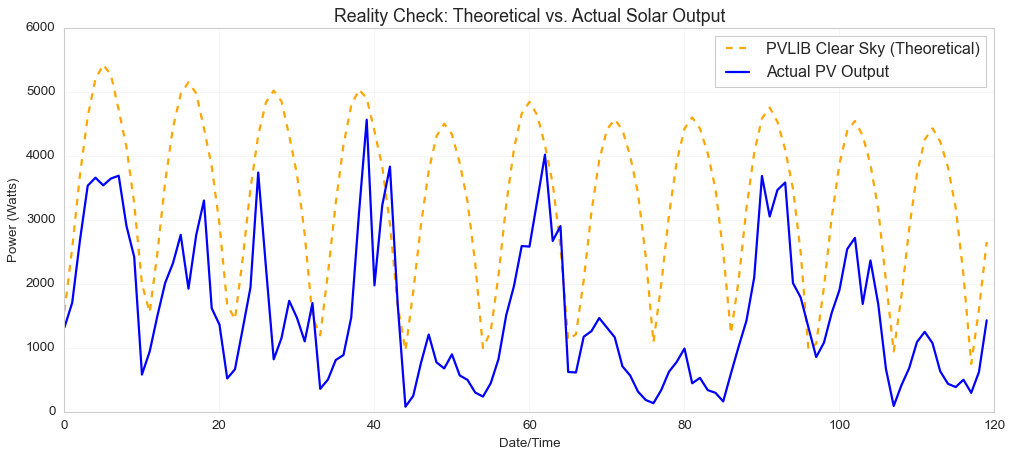

In [168]:
import matplotlib.pyplot as plt

# 1. Select a slice of data (e.g., 5 days from the test set)
# We pick a start point and take 120 hours (5 days * 24 hours)
start_idx = 0  # Change this to look at different weeks!
end_idx   = start_idx + 120

subset = df_daytime_test.iloc[start_idx:end_idx]

# 2. Setup the Plot
plt.figure(figsize=(15, 6))

# 3. Plot the Curves
# The "Theoretical Maximum" (PVLIB)
plt.plot(subset.index, subset['Total_Power_ClearSky_Output(W)'], 
         label='PVLIB Clear Sky (Theoretical)', color='orange', linestyle='--', linewidth=2)

# The "Actual Reality"
plt.plot(subset.index, subset['PV(W)'], 
         label='Actual PV Output', color='blue', linewidth=2)

# Optional: Plot your Hybrid Prediction if you have it!
# plt.plot(subset.index, y_pred_hybrid[start_idx:end_idx], label='Hybrid Prediction', color='green')

# 4. Make it readable
plt.title('Reality Check: Theoretical vs. Actual Solar Output', fontsize=16)
plt.ylabel('Power (Watts)', fontsize=12)
plt.xlabel('Date/Time', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [169]:
# --- 1. Reconstruct Actual Values (same as before) ---
# We need the real PV output to compare against ClearSky
train_actual_pv = (y_train + df_daytime_train['Total_Power_ClearSky_Output(W)'])
train_clearsky  = df_daytime_train['Total_Power_ClearSky_Output(W)']

# --- 2. Calculate the "System Efficiency Factor" ---
# We only look at the top 10% of high-power times to ignore cloudy days.
# This gives us the ratio when the sun IS shining.
high_power_mask = train_actual_pv > train_actual_pv.quantile(0.90)

# Calculate ratio (Actual / ClearSky) for these bright moments
performance_factor = (train_actual_pv[high_power_mask] / train_clearsky[high_power_mask]).median()

print(f"☀️ Calculated System Performance Factor: {performance_factor:.4f}")
print("This means your system is performing at about {:.1f}% of the theoretical maximum.".format(performance_factor*100))

# --- 3. Create the NEW Corrected Target ---
# New Baseline = ClearSky * Factor
# New Target   = Actual - New Baseline
new_base_train = train_clearsky * performance_factor
new_target_train = train_actual_pv - new_base_train

new_base_test = df_daytime_test['Total_Power_ClearSky_Output(W)'] * performance_factor
y_test_actual_reconstructed = (y_test + df_daytime_test['Total_Power_ClearSky_Output(W)']) # Actual Test PV

# --- 4. Train a New Linear Regression on this Corrected Target ---
print("\nTraining new Calibrated Residual Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, new_target_train)

# --- 5. Predict and Evaluate ---
# Predict the error
y_pred_new_error = lr_model.predict(X_test)

# Add error back to the NEW baseline
y_pred_final_calibrated = (y_pred_new_error + new_base_test).clip(lower=0)

# Calculate Metrics
from sklearn.metrics import mean_squared_error, r2_score
rmse_calib = np.sqrt(mean_squared_error(y_test_actual_reconstructed, y_pred_final_calibrated))
n_rmse_calib = rmse_calib / y_test_actual_reconstructed.mean()
r2_calib = r2_score(y_test_actual_reconstructed, y_pred_final_calibrated)

print(f"\n--- Results for Calibrated Model (Factor: {performance_factor:.2f}) ---")
print(f"R² Score:  {r2_calib:.4f}")
print(f"RMSE:      {rmse_calib:.2f} W")
print(f"nRMSE:     {n_rmse_calib:.4f} ({n_rmse_calib*100:.2f}%)")

☀️ Calculated System Performance Factor: 1.0001
This means your system is performing at about 100.0% of the theoretical maximum.

Training new Calibrated Residual Model...

--- Results for Calibrated Model (Factor: 1.00) ---
R² Score:  1.0000
RMSE:      0.22 W
nRMSE:     0.0001 (0.01%)


In [170]:
# NOTE: Feature importance and Monte Carlo uncertainty analysis are not applicable to Linear Regression
# These are Random Forest specific features that have been commented out
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 
# --- 1. Select Model and Baseline ---
# if 'lr_model' in locals():
#     print("Using Calibrated Model (lr_model) for Uncertainty Analysis...")
#     model_to_use = lr_model
#     baseline_to_use = new_base_test
# else:
#     print("Using Standard Model (lr_model) for Uncertainty Analysis...")
#     model_to_use = lr_model
#     baseline_to_use = df_daytime_test['Total_Power_ClearSky_Output(W)']
# 
# --- 2. Monte Carlo Simulation ---
# print("Running Monte Carlo simulation on forest trees... (this may take a moment)")
# tree_preds = np.array([tree.predict(X_test.values) for tree in model_to_use.estimators_]).T
# 
# Add baseline to get full PV Watts
# baseline_array = baseline_to_use.values.reshape(-1, 1)
# all_tree_pv_predictions = (tree_preds + baseline_array).clip(min=0)
# 
# --- 3. Calculate Ensemble Statistics ---
# We use the Median as our primary "Point Prediction" for accuracy metrics
# median_pred = np.median(all_tree_pv_predictions, axis=1)
# lower_bound = np.percentile(all_tree_pv_predictions, 5, axis=1)
# upper_bound = np.percentile(all_tree_pv_predictions, 95, axis=1)
# 
# actual_values = y_test_actual_reconstructed.values
# 
# --- 4. Calculate Performance Metrics (RMSE, MAE, R2) ---
# rmse = np.sqrt(mean_squared_error(actual_values, median_pred))
# mae = mean_absolute_error(actual_values, median_pred)
# r2 = r2_score(actual_values, median_pred)
# 
# Calculate Percentage Metrics (normalized by the mean of actual values)
# Note: You can change the denominator to 'max(actual_values)' if you prefer capacity-based normalization
# normalization_factor = np.mean(actual_values)
# p_rmse = (rmse / normalization_factor) * 100
# p_mae = (mae / normalization_factor) * 100
# 
# --- 5. Calculate Uncertainty Metrics ---
# is_in_bounds = (actual_values >= lower_bound) & (actual_values <= upper_bound)
# coverage_score = np.mean(is_in_bounds) * 100
# avg_width = np.mean(upper_bound - lower_bound)
# 
# --- 6. Print Results ---
# print(f"\n{'='*40}")
# print(f"       MODEL PERFORMANCE REPORT       ")
# print(f"{'='*40}")
# print(f"Performance Metrics (based on Median):")
# print(f"-------------------------------------")
# print(f"RMSE:         {rmse:.2f} W")
# print(f"MAE:          {mae:.2f} W")
# print(f"R² Score:     {r2:.4f}")
# print(f"pRMSE %:      {p_rmse:.2f} %")
# print(f"pMAE %:       {p_mae:.2f} %")
# print(f"\nUncertainty / Risk Metrics:")
# print(f"-------------------------------------")
# print(f"Coverage (90% CI):      {coverage_score:.2f} %")
# print(f"Avg Interval Width:     {avg_width:.2f} W")
# 
# if coverage_score < 80:
#     print(">> Diagnosis: OVER-CONFIDENT. (Intervals are too narrow)")
# elif coverage_score > 95:
#     print(">> Diagnosis: UNDER-CONFIDENT. (Intervals are too wide)")
# else:
#     print(">> Diagnosis: WELL-CALIBRATED. (Reliable uncertainty)")
# 
# --- 7. Visualization ---
# plt.figure(figsize=(15, 6))
# slice_idx = 0 
# slice_end = 120 
# 
# plt.plot(actual_values[slice_idx:slice_end], label='Actual PV', color='black', linewidth=2)
# plt.plot(median_pred[slice_idx:slice_end], label='Median Prediction', color='blue', linestyle='--')
# plt.fill_between(range(slice_end - slice_idx), 
#                  lower_bound[slice_idx:slice_end], 
#                  upper_bound[slice_idx:slice_end], 
#                  color='blue', alpha=0.3, label='90% Confidence Interval')
# 
# plt.title(f'Monte Carlo Forecast: RMSE={rmse:.1f}W | pRMSE={p_rmse:.1f}%', fontsize=14)
# plt.ylabel('Power Output (W)')
# plt.xlabel('Hours')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

Write results to CSV file

In [171]:
with open(f'results/linear_regression_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/linear_regression_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("Linear Regression Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}"  )
    line.append(f"{test_n_mae*100:.4f}"  )
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}"  )
    line.append(f"{train_n_mae*100:.4f}"  )
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}"  )
    line.append(f"{test_n_mae_pvw*100:.4f}"  )
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}"  )
    line.append(f"{train_n_mae_pvw*100:.4f}"  )
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')